# Market generator

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import datetime

# import base
import BuehlerVAE.src.market_generator as market_generator
from BuehlerVAE.src.utils import tosig

c:\Users\peter\OneDrive - TUM\Master TUM\Masterarbeit\MarketGenerators\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Signature order
order = 4

## Load monthly paths

In [3]:
# ^GSPC is S&P 500.
ticker = "^GSPC"
params = {
            "M": 1000, # number of paths
            "H": 0.14,
            "rho": -0.85,
            "xi0": 0.1,
            "nu": 1.5,
            "S0": 1.
          }
MG = market_generator.MarketGenerator(ticker, start=datetime.date(2000, 1, 1),
                                      freq="M", sig_order=order, rough_bergomi=params)

Computing log-signatures: 100%|██████████| 1000/1000 [00:00<00:00, 7013.37it/s]


## Plot paths

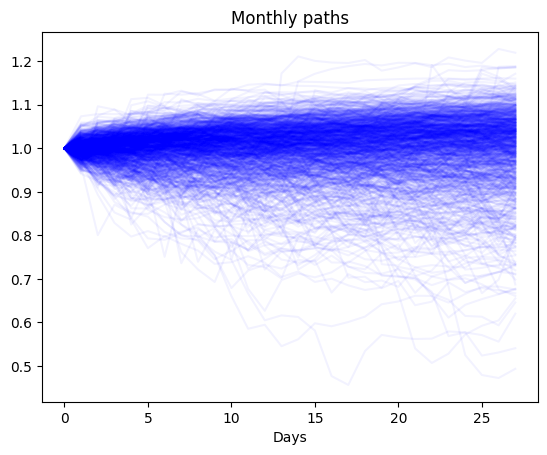

In [4]:
for path in MG.windows:
    returns = path[::2, 1]
    plt.plot(returns, "b", alpha=0.05)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

## Train generative model

In [5]:
MG.train(n_epochs=10000)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Training: 100%|██████████| 10000/10000 [00:23<00:00, 425.07it/s]


## Generate

In [6]:
generated = np.array([MG.generate(cond) for cond in MG.conditions])
#generated = MG.generate(MG.conditions[100], n_samples=len(MG.logsigs))
#generated = MG.generate(MG.conditions[150][2] * 0.5, n_samples=len(MG.logsigs))

generated_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated)])
real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(MG.orig_logsig)])

100%|██████████| 1000/1000 [00:21<00:00, 46.75it/s]


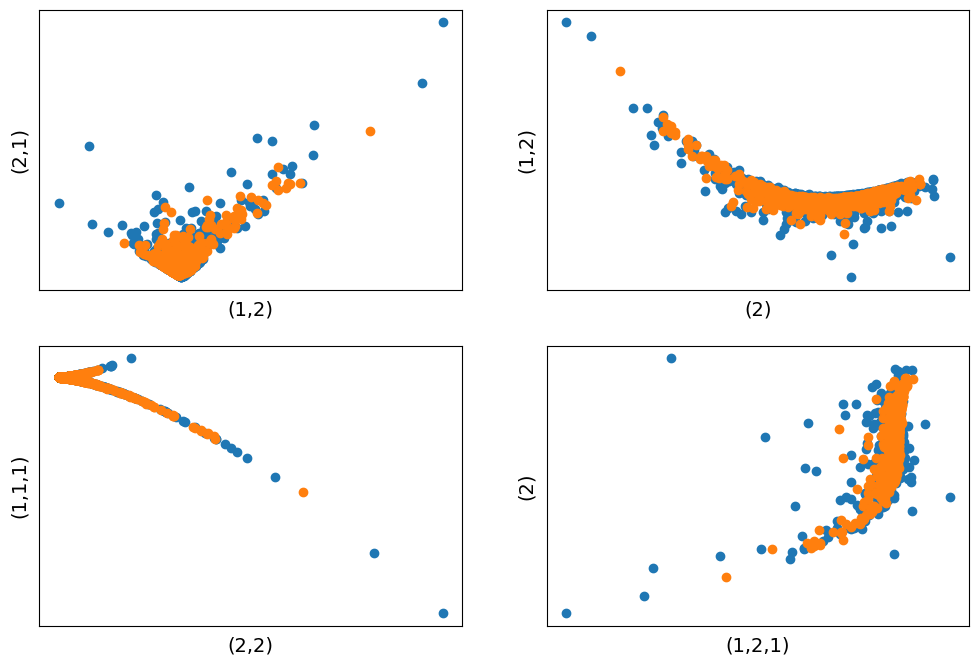

In [7]:
from esig.tosig import sigkeys

keys = sigkeys(2, order).split()

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (9, 2)]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)

    plt.scatter(real_sigs[:, projection[0]], real_sigs[:, projection[1]],
                label="Real data")
    plt.scatter(generated_sigs[:, projection[0]], generated_sigs[:, projection[1]],
               label="Generated")
    plt.xlabel(keys[projection[0]], fontsize=14)
    plt.ylabel(keys[projection[1]], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    #plt.legend()
    
plt.show()

## Validation: two-sample statistical test

In [8]:
import BuehlerVAE.src.process_discriminator as process_discriminator

normalised_generated = np.array([MG.generate(cond, normalised=True) for cond in MG.conditions])
sigs1 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(normalised_generated)])
MG._load_rough_bergomi(params)
sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(MG.logsigs)])

res = process_discriminator.test(sigs1, sigs2, order=order, compute_sigs=False,
                                 confidence_level=0.999)

print("Are the generated and real distributions DIFFERENT? {}".format(res))

Computing signatures of population 2: 100%|██████████| 999/999 [00:00<00:00, 1647.26it/s]

Are the generated and real distributions DIFFERENT? False


## Invert log-signature

In [9]:
import BuehlerVAE.src.logsig_inversion as logsig_inversion
from esig.tosig import stream2logsig
from BuehlerVAE.src.utils.leadlag import leadlag

logsig = MG.generate(MG.conditions[0])

In [10]:
pip = 0.001
n_pips = 5 * 10
n_points = 21

n_iterations = 100
n_organisms = 100

recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                              pip, n_pips)

Loss: 0.12021568326796356: 100%|██████████| 100/100 [00:05<00:00, 19.50it/s]


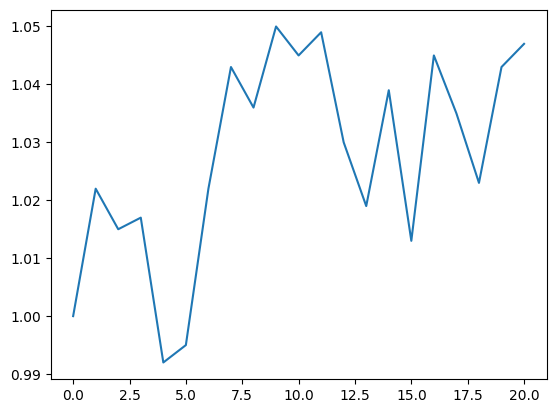

Target log-signature: [0.04694703221321106, 0.04694002494215965, -0.0016782113816589117, -2.581848093541339e-05, -4.925250323140062e-06, 2.0356560526124667e-06, 1.7014665445458377e-06, 2.7971151439487585e-07]
Recovered log-signature: [0.047, 0.047, -0.0029345, 2.78591666666666e-06, -4.936916666666674e-06, 3.78999999999768e-10, 1.2230754166666672e-07, -1.9592500000000385e-08]


In [11]:
plt.plot(1 + recovered_path)
plt.show()
print(f"Target log-signature: {logsig.tolist()}")
print(f"Recovered log-signature: {stream2logsig(leadlag(recovered_path), order).tolist()}")

In [12]:
paths = []
for condition in MG.conditions:
    logsig = MG.generate(condition)
    recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                                  pip, n_pips)
    
    paths.append(recovered_path)

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.025415247648783907: 100%|██████████| 100/100 [00:05<00:00, 18.65it/s]


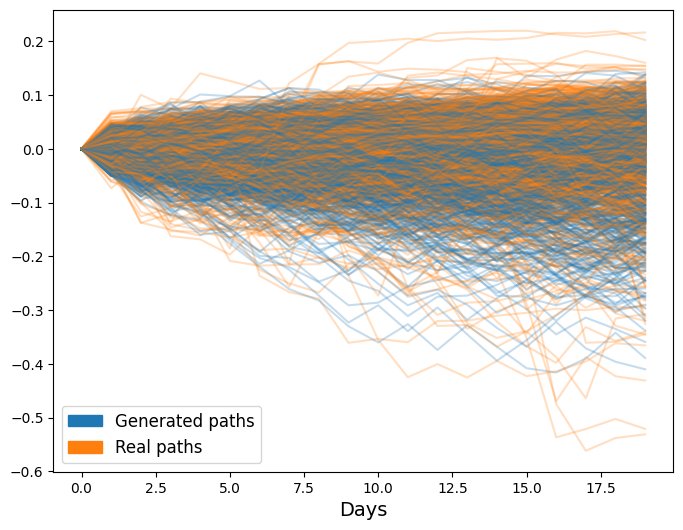

In [13]:
import matplotlib.patches as mpatches

plt.figure(figsize=(8, 6))
for path1, path2 in zip(paths, MG.windows):
    returns = path2[::2, 1][:20] - path2[0, 1]
    plt.plot(returns, "C1", alpha=0.25)

    plt.plot(path1[:20], "C0", alpha=0.25)
    
    
blue_patch = mpatches.Patch(color='C0', label='Generated paths')
red_patch = mpatches.Patch(color='C1', label='Real paths')
plt.legend(handles=[blue_patch, red_patch], fontsize=12)    
plt.xlabel("Days", fontsize=14) 
plt.show()

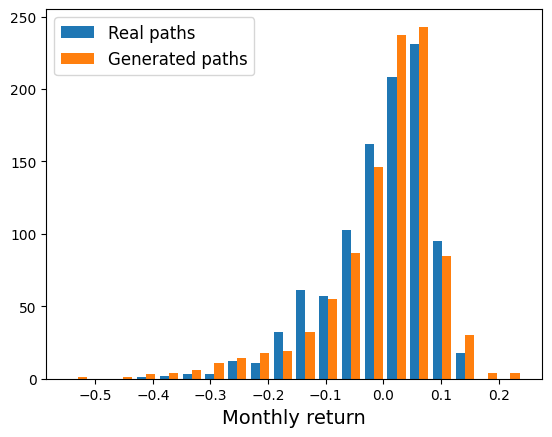

In [14]:
returns1 = [path[-1] - path[0] for path in paths]
returns2 = [path[-1, 1] - path[0, 0] for path in MG.windows]

_ = plt.hist([returns1, returns2], bins=20, label=["Real paths", "Generated paths"])
plt.xlabel("Monthly return", fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [15]:
def concatenate(condition, periods):
    joined_path = None

    for _ in range(periods):
        generated = MG.generate(condition)
        path, loss = logsig_inversion.train(generated, order, n_iterations, n_organisms, n_points,
                                            pip, n_pips)

        condition = tosig.stream2logsig(market_generator.leadlag(recovered_path), order)
        condition = MG.scaler.transform([condition])[0]

        if joined_path is None:
            joined_path = path
        else:
            joined_path = np.r_[joined_path, np.add(path[1:], joined_path[-1])]
            
    return joined_path

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.07858262738807523: 100%|██████████| 100/100 [00:04<00:00, 21.85it/s]


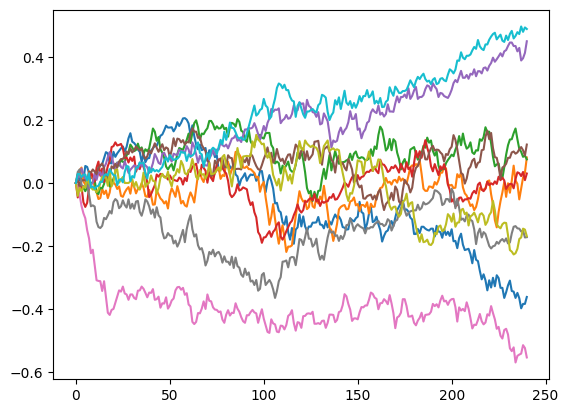

In [16]:
idx = 220

condition = MG.conditions[idx]

paths = [concatenate(condition, 12) for _ in range(10)]

plt.plot(np.transpose(paths))
plt.show()

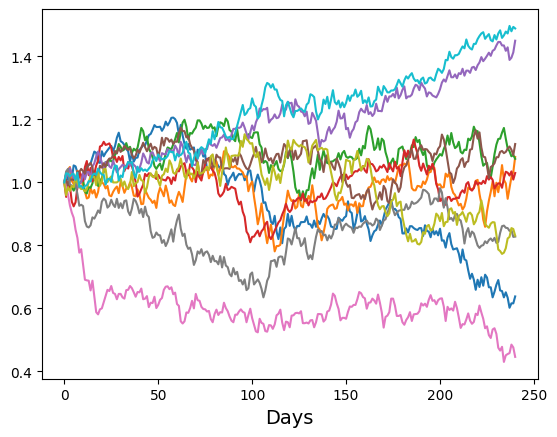

In [17]:
plt.plot(MG.windows[idx + 1][0, 0] + np.transpose(paths))
plt.xlabel("Days", fontsize=14) 
plt.show()

# Eigene Versuche

In [18]:
MG.windows[0]

    # returns = path[::2, 1]
    # plt.plot(returns, "b", alpha=0.05)

array([[1.        , 1.        ],
       [1.        , 0.99806316],
       [0.99806316, 0.99806316],
       [0.99806316, 1.00446083],
       [1.00446083, 1.00446083],
       [1.00446083, 1.02166329],
       [1.02166329, 1.02166329],
       [1.02166329, 1.01629042],
       [1.01629042, 1.01629042],
       [1.01629042, 1.02328977],
       [1.02328977, 1.02328977],
       [1.02328977, 1.04574834],
       [1.04574834, 1.04574834],
       [1.04574834, 1.02810739],
       [1.02810739, 1.02810739],
       [1.02810739, 0.99701107],
       [0.99701107, 0.99701107],
       [0.99701107, 0.94337361],
       [0.94337361, 0.94337361],
       [0.94337361, 0.9470256 ],
       [0.9470256 , 0.9470256 ],
       [0.9470256 , 0.9677934 ],
       [0.9677934 , 0.9677934 ],
       [0.9677934 , 0.97794475],
       [0.97794475, 0.97794475],
       [0.97794475, 0.98380384],
       [0.98380384, 0.98380384],
       [0.98380384, 0.97515711],
       [0.97515711, 0.97515711],
       [0.97515711, 0.96644405],
       [0.

In [19]:
MG.conditions

array([[0.85304126, 0.85304126, 0.97748263, ..., 0.87986899, 0.83551929,
        0.96027857],
       [0.71685739, 0.71685739, 0.9425905 , ..., 0.87926573, 0.83455762,
        0.95870909],
       [0.79600771, 0.79600771, 0.87885094, ..., 0.86783525, 0.81938811,
        0.94220084],
       ...,
       [0.49837198, 0.49837198, 0.88530414, ..., 0.87698253, 0.83248362,
        0.95666312],
       [0.60243551, 0.60243551, 0.97667145, ..., 0.87934533, 0.83436977,
        0.9587526 ],
       [0.61959568, 0.61959568, 0.81574868, ..., 0.86452047, 0.81011525,
        0.92732658]])

# Rough Bergomi sandbox

In [20]:
from BuehlerVAE.src import rough_bergomi as rb
rb_paths = rb.rough_bergomi(
    grid_points=28, # points in the simulation grid
    M=10, # paths to simulate
    H=0.14, # Hurst Index
    T=28/252,
    rho=-0.85,
    xi0=0.1,
    nu=1.5,
    S0=1.
)
rb_paths




array([[1.        , 0.98901425, 1.00199718, 0.99992689, 1.00012884,
        1.00957825, 1.00101215, 0.97615308, 0.9452736 , 0.93843307,
        0.94527871, 0.94701502, 0.9733718 , 0.97891544, 0.98436534,
        0.98812628, 0.98995275, 0.97898966, 0.97285867, 0.96793029,
        0.97993349, 0.98974873, 0.98085233, 0.98332498, 0.98525544,
        0.98714044, 0.98196313, 0.98111171],
       [1.        , 0.97706043, 0.91159087, 0.91195233, 0.91840629,
        0.88811712, 0.954114  , 0.947409  , 0.93880935, 0.93734427,
        0.94031506, 0.94588824, 0.95108977, 0.95431501, 0.9602355 ,
        0.96184793, 0.96295156, 0.96064965, 0.95933338, 0.94838474,
        0.94447615, 0.943602  , 0.94952033, 0.95523377, 0.95106654,
        0.96495283, 0.9656777 , 0.96666362],
       [1.        , 0.99103937, 0.98530299, 0.95978971, 0.96656788,
        0.97243408, 0.94625245, 0.9539862 , 0.93966238, 0.94451182,
        0.96522873, 0.98440926, 0.9891718 , 0.985835  , 1.01059122,
        1.01238465, 1.0109

In [21]:
import BuehlerVAE.src.market_generator as market_generator
order = 4
ticker = "^GSPC"
params = {
            "M": 1000, # number of paths
            "H": 0.14,
            "rho": -0.85,
            "xi0": 0.1,
            "nu": 1.5,
            "S0": 1.
          }
kou_params = {
    "S0": 1., 
    "mu": 0.12, 
    "sigma": 0.2, 
    "lambda_": 2.0, 
    "p": 0.3, 
    "eta1": 50., 
    "eta2": 25., 
    "T": 28/252, 
    "dt": 1/28, 
    "n": 10
}
MG = market_generator.MarketGenerator(ticker, freq="M", sig_order=order, kou_jump=kou_params)

TypeError: __init__() got an unexpected keyword argument 'kou_jump'

In [ ]:
print(MG.logsigs)
print(MG.conditions.shape)
print(MG.orig_logsig)

9.99999999995449e-06
(999, 8)
[[ 6.57353218e-02  6.57353218e-02 -1.13522075e-03 ... -1.76057582e-08
   1.14889002e-07  6.91487828e-08]
 [ 8.21257074e-02  8.21257074e-02 -1.91886776e-03 ... -4.09613994e-07
  -6.64086132e-07 -3.50071722e-07]
 [ 2.78392277e-02  2.78392277e-02 -2.85362605e-03 ... -5.22197498e-07
  -7.93819178e-07 -4.41408030e-07]
 ...
 [ 2.16842848e-02  2.16842848e-02 -3.96119317e-03 ... -2.18103799e-06
  -4.31806362e-06 -2.63341383e-06]
 [ 6.39379322e-03  6.39379322e-03 -1.52722057e-03 ... -7.55863849e-07
  -1.69819546e-06 -1.01936439e-06]
 [-2.61541729e-02 -2.61541729e-02 -1.85142770e-03 ... -1.09297945e-06
  -2.04679933e-06 -1.03416223e-06]]
